# ARIM-Academy：　機器データ利活用ユースケース
### 機器：蛍光分光光度計　（励起-蛍光マトリクス3次元蛍光法）

### 分析：1 クラス分類アルゴリズム畳み込みオートエンコーダ (OC-CAE)


## データセット
本データセット「ツバキ油データセット」（CAO.mat）は、純正のツバキ油およびそれに異なる割合で混入された大豆油（SBO）、ピーナッツ油（PO）、ヒマワリ油（SO）の二元混合油サンプルに関するEEM（励起-発光マトリックス）蛍光スペクトルデータです。本データセットは、食品の真正性検証に関する研究に使用され、ツバキ油の偽造検出を目的としています[1]。  

このデータセットを用いた研究では、異常検出のための1クラス分類アルゴリズムである1クラス畳み込みオートエンコーダ（OC-CAE）を使用します。OC-CAEは、再構成誤差の解析にBoxplotを使用し、CAEの隠れ層で抽出された特徴を用いて局所外れ値因子（LOF）アルゴリズムを適用し、食品の真正性を識別します。  


[1]  Xiaoqin Yan, Baoshuo Jia, Wanjun Long, Kun Huang, Tong Wang, Hailong Wu, Ruqin Yu  "A Novel One-Class Convolutional Autoencoder Combined With Excitation–Emission Matrix Fluorescence Spectroscopy for Authenticity Identification of Food", Journal of Chemometrics, e3592 (2024)  
https://doi.org/10.1002/cem.3592c02495

---
<br>  
<img src="./img/main_image.jpg" width="50%">
<br>

---

### 教材への接続
google colabにおけるオンラインの場合にこのラインを実行します。（<font color="red">Google colabに接続しない場合には不要</font>）

In [ ]:
!git clone https://github.com/ARIM-Usecase/Example_6.git
%cd Example_6

### ライブラリのインポート
コード実行で必要なpythonのライブラリをimport文でロードします。

In [1]:
#I/Oライブラリ
import scipy.io as scio

# 汎用ライブラリ
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 機械学習
from sklearn.neighbors import LocalOutlierFactor as LOF
from sklearn import metrics
from pyod.models.lof import LOF as PYOD_LOF
from sklearn.svm import OneClassSVM

# 深層学習
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.transforms import Resize
from torch.utils.data import DataLoader, Dataset

## 1. サンプルファイルの読み込み

### MATLABデータの読み込み
MATLAB形式のデータファイル（.mat）を読み込み、データの前処理を行う関数 load_and_preprocess_data を事前に定義しておきます。引数の`scale_factor`: デフォルト値6000で、データをスケールダウンするための因子です。

In [2]:
# Data Preprocessing
def load_and_preprocess_data(filepath, scale_factor=6000):
    yxqdata = scio.loadmat(filepath)
    keys = ['X_training_normal', 'X_training', 'X_test', 'X_pre']
    data = {key: yxqdata[key] / scale_factor for key in keys}
    
    for key in data:
        data[key][data[key] < 0] = 0

    labels = {key: (yxqdata[key.replace('X', 'Y')]).squeeze() for key in keys}
    
    return data, labels

In [3]:
data, labels = load_and_preprocess_data('./data/CAO.mat')

【解説】
- `scipy.io`（`scio`）の `loadmat` 関数を使って、指定されたファイルパスからMATLABデータを読み込みます。`yxqdata` には、読み込んだデータが辞書形式で格納されます。
- `keys` というリストには、読み込むデータのキーが含まれています。
- 辞書内包表記を使って、各キーに対してデータをスケールダウンします。
- 次に、各データセット内の負の値を0に置き換えます。
- 同様に、`labels` という辞書を作成します。各キーの名前を `X` から `Y` に置き換えて、対応するラベルデータを抽出します。また、`squeeze()` メソッドを使用して、不要な次元を削除します。

### 画像変換
data_resize()関数を定義しでデータをリサイズします。ここでは入力データを [チャネル数, 高さ, 幅] 形式に変換します。続いて、NumPy配列をPyTorchテンソルに変換し、リサイズ処理に適した形状に変換します。

In [4]:
def data_resize(data, a, b):
    data_1 = np.moveaxis(data, -1, 0)
    data_1 = torch.from_numpy(data_1.astype(np.float32)).unsqueeze(0)
    torch_resize = Resize([a, b])
    data_resize = torch_resize(data_1)
    data_resize = data_resize.squeeze(0).numpy()
    
    return np.moveaxis(data_resize, 0, -1)

In [5]:
for key in data:
    data[key] = data_resize(data[key], 80, 120)

## 2. データセット定義
PyTorchの `Dataset` クラスを継承して、カスタムデータセットクラス `yxqDataset` を定義しています。このクラスは、モデルをトレーニングする際にデータとラベルを扱うためのものです。

In [6]:
# Dataset Definition
class yxqDataset(Dataset):
    def __init__(self, data, labels, transform=None):
        self.labels = labels
        self.imgs = data
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.imgs[:, :, idx]
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label


各メソッドの簡単な説明は次の通りです：

1. **`__init__` メソッド**：
   - 初期化関数で、データ (`data`)、ラベル (`labels`)、およびデータに適用する変換 (`transform`) を受け取ります。
   - `self.labels` にラベルを、`self.imgs` にデータ（画像）を格納します。`self.transform` には、もし変換が指定されていれば格納します。

2. **`__len__` メソッド**：
   - データセットの長さ（つまり、データの総数）を返します。`len(self.labels)` でラベルの数を取得して返しています。

3. **`__getitem__` メソッド**：
   - 指定されたインデックス `idx` に基づいて、対応する画像とラベルのペアを返します。
   - 画像は `self.imgs[:, :, idx]` で取得され、対応するラベルは `self.labels[idx]` で取得されます。
   - もし、`transform` が指定されていれば、画像に対してその変換を適用してから返します。

このクラスにより、PyTorchのデータローダーで扱える形式のデータセットが簡単に作成できます。

### 画像データをテンソル形式に変換
PyTorchの `transforms` モジュールから `ToTensor()` 変換が呼び出し、**画像データをテンソル形式に変換**する処理を行います。この変換を適用することで、画像をPyTorchのニューラルネットワークに入力できる形式（テンソル）に変換できるようになります。

In [7]:
data_tf = transforms.ToTensor()

【解説】`ToTensor()`メソッド  は：
- `ToTensor()` は、通常 **PIL画像**（またはNumPy配列）のデータを **PyTorchテンソル** に変換します。
- 画像のピクセル値が通常0から255の範囲ですが、`ToTensor()` はそれらを0から1の範囲に正規化します（データ型が `float32` になりになります。

## データのロード
PyTorchの DataLoader を使ってデータのローディングプロセスを定義します。データセットとラベルをバッチ単位で扱い、訓練に必要なデータを準備するための関数です。

In [8]:
def create_dataloader(data, labels, batch_size=16, shuffle=True):
    dataset = yxqDataset(data, labels, transform=data_tf)
    
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

In [9]:
train_normal_loader = create_dataloader(data['X_training_normal'], labels['X_training_normal'])

## 3.畳み込みオートエンコーダー（CAE）

畳み込みオートエンコーダー（CAE: Convolutional Autoencoder）を定義します。CAEは、入力データを圧縮し、その後に再構成するニューラルネットワークモデルで、主にデータの次元削減やノイズ除去、特徴抽出などに用いられます。

In [10]:
# Define CAE
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        self.encoder1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU()
        )
        self.encoder1_pool = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)
        self.encoder2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=0),
            nn.ReLU()
        )
        self.encoder2_pool = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)
        self.fc1 = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32 * 19 * 29, 120),
            nn.Linear(120, 32)
        )
        self.fc2 = nn.Sequential(
            nn.Linear(32, 120),
            nn.Linear(120, 32 * 19 * 29),
            nn.Unflatten(1, (32, 19, 29))
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=1, padding=1),
            nn.Tanh()
        )
        self.unpool1 = nn.MaxUnpool2d(kernel_size=2, stride=2)
        self.unpool2 = nn.MaxUnpool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.encoder1(x)
        x, ind1 = self.encoder1_pool(x)
        x = self.encoder2(x)
        x, ind2 = self.encoder2_pool(x)
        encoded = self.fc1(x)
        x = self.fc2(encoded)
        x = self.unpool1(x, ind2)
        x = self.decoder[0:2](x)
        x = self.unpool2(x, ind1)
        decoded = self.decoder[2:](x)
        
        return encoded, decoded

### 各部分の説明：

1. **クラス定義と初期化 (`__init__`)**:
   - `ConvAutoencoder` は、PyTorchの `nn.Module` を継承して作成され、エンコーダー（データを圧縮）とデコーダー（データを再構成）を持ちます。
   - `super(ConvAutoencoder, self).__init__()` によって、親クラス（`nn.Module`）の初期化関数を呼び出します。

2. **エンコーダー部分**:
   - **`encoder1`**:
     - `nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)`：1チャンネルの入力画像を16チャンネルに変換する2D畳み込み層。
     - `nn.ReLU()`：活性化関数としてReLUを使用します。
   - **`encoder1_pool`**:
     - `nn.MaxPool2d` を使って、プーリング操作を行い、特徴マップの次元を削減します。`return_indices=True` によって、プーリングの際に選ばれたインデックスも保持します（後で逆操作に使用）。
   - **`encoder2`**:
     - 2つ目の畳み込み層で、16チャンネルから32チャンネルに変換します。
   - **`encoder2_pool`**:
     - さらにプーリングして次元削減を行います。

3. **全結合層**:
   - **`fc1`**（圧縮部分）:
     - `nn.Flatten()` でデータを1次元に変換し、次に `nn.Linear(32 * 19 * 29, 120)` で線形変換を行い、さらに圧縮します。その後、最終的に `nn.Linear(120, 32)` で32次元のベクトルに圧縮します。
   - **`fc2`**（復元部分）:
     - `fc1` の逆操作として、再度高次元に変換します。`nn.Linear(32, 120)` で120次元に拡張し、さらに `nn.Linear(120, 32 * 19 * 29)` で畳み込み層の入力次元に戻します。
     - `nn.Unflatten(1, (32, 19, 29))` でテンソルを2D画像形式に戻します。

4. **デコーダー部分**:
   - **`decoder`**:
     - `nn.ConvTranspose2d(32, 16, kernel_size=3)`：逆畳み込み層を使い、32チャンネルから16チャンネルに変換し、次に1チャンネルに戻します。
     - `nn.Tanh()`：出力層でtanh活性化関数を使い、値を [-1, 1] の範囲に正規化します。

5. **アンプーリング (`unpool1` と `unpool2`)**:
   - プーリングで保持していたインデックス (`ind1`, `ind2`) を使って、`MaxUnpool2d` で元のサイズに逆変換します。

### 順伝播 (`forward`) メソッド：
1. **エンコーディング**:
   - 入力データ `x` を `encoder1` と `encoder1_pool` に通し、次に `encoder2` と `encoder2_pool` に通して特徴マップを圧縮します。この時、各プーリング操作でインデックスを取得します（`ind1`, `ind2`）。
   - その後、全結合層 `fc1` を使ってデータをさらに圧縮して、32次元のベクトル `encoded` にします。

2. **デコーディング**:
   - `fc2` を使って、32次元のベクトルを元の形状に復元し、次にアンプーリング操作を行ってデータの次元を拡張します。
   - 逆畳み込み層で元の1チャンネル画像に再構成し、最終的に `decoded` として出力します。

### モデル定義
モデルのインスタンスを作成し、オートエンコーダーモデルの学習に必要な設定として損失関数と最適化アルゴリズムを定義します。ここではモデル（`ConvAutoencoder`）に対してMSEを基準に誤差を計算し、Adam最適化アルゴリズムを使ってパラメータを更新させます。

In [11]:
model = ConvAutoencoder()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

1. **`model = ConvAutoencoder()`**:
   - 先ほど定義した `ConvAutoencoder` クラスのインスタンスを作成しています。これにより、畳み込みオートエンコーダーモデルが初期化され、使用可能になります。

2. **`criterion = nn.MSELoss()`**:
   - 損失関数として **平均二乗誤差 (MSE: Mean Squared Error)** を使用します。MSEは、モデルの出力（再構成された画像）と、元の入力画像との間の誤差（差の二乗の平均）を計算し、これを最小化するようにモデルを訓練します。
   - オートエンコーダーの場合、入力画像と復元画像の差を評価するためにMSEがよく使われます。

3. **`optimizer = optim.Adam(model.parameters(), lr=1e-3)`**:
   - **Adam最適化アルゴリズム** を使用して、モデルの重みを更新します。Adamは、勾配降下法の一種で、学習率の自動調整や慣性を考慮することで、効率的に学習を進めることができます。
   - `model.parameters()` で、モデル内の全ての学習可能なパラメータ（重みとバイアス）を指定しています。
   - `lr=1e-3` で学習率を設定しており、この値はパラメータの更新のステップサイズを決定します。1e-3（0.001）は一般的な初期設定ですが、後で調整することもあります。

In [12]:
#評価値の記録用データフレームの作成
df = pd.DataFrame(columns=['epoch', 'train_loss'])
df.to_csv('./result/CAO/loss/CAO_loss1.csv', index=False)

### トレーニングの定義
このコードでは、モデルのトレーニングを実際に行う関数 `train_model` を定義します。トレーニングデータを複数のエポックにわたってモデルに通し、損失を最小化するためにモデルのパラメータを更新させます。また、各エポックの損失をCSVファイルに保存します。力に表示するとともに、損失値をCSVファイルに保存して後で確認できるようにしています。

In [13]:
# Training Function
def train_model(num_epochs, model, train_loader, criterion, optimizer):
    train_losses = []
    for epoch in range(num_epochs):
        train_loss = 0.0
        model.train()
        for img, _ in train_loader:
            img = img.float()
            train_recon, train_recon2 = model(img)
            loss = criterion(train_recon2, img)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * img.size(0)
        
        train_loss /= len(train_loader.dataset)
        print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss:.6f}')
        train_losses.append(train_loss)
        df = pd.DataFrame([[epoch + 1, train_loss]])
        df.to_csv('./result/CAO/loss/CAO_loss1.csv', mode='a', header=False, index=False)

    return train_losses

### 各部分の説明：
1. **`train_model` 関数**:
   - **引数**:
     - `num_epochs`: 訓練を行うエポック数。
     - `model`: 訓練するオートエンコーダーモデル。
     - `train_loader`: トレーニングデータを供給するデータローダー。
     - `criterion`: 損失関数（ここではMSE）。
     - `optimizer`: パラメータを更新するための最適化アルゴリズム（ここではAdam）。
   
   - **戻り値**: 
     - `train_losses`: 各エポックごとの損失が格納されたリスト。

2. **トレーニングループ (`for epoch in range(num_epochs)`)**:
   - エポックごとにトレーニングを行います。
   - 各エポックで、`train_loss = 0.0` としてエポックごとのトレーニング損失を初期化し、ミニバッチごとに損失を積算します。

3. **ミニバッチトレーニング (`for img, _ in train_loader`)**:
   - データローダー `train_loader` からミニバッチ（`img`）を取得して、モデルに通します。
   - **`model.train()`** は、モデルをトレーニングモードに設定します（ドロップアウトやバッチ正規化などが有効になります）。
   
4. **順伝播と損失計算**:
   - `train_recon, train_recon2 = model(img)` で、オートエンコーダーモデルに画像を入力し、出力（`train_recon2`）を得ます。
   - `loss = criterion(train_recon2, img)` で、モデルの再構成された画像（`train_recon2`）と元の画像（`img`）との間の誤差（損失）を計算します。

5. **逆伝播とパラメータ更新**:
   - `optimizer.zero_grad()` で勾配を初期化し、`loss.backward()` で誤差の逆伝播を行います。
   - `optimizer.step()` でモデルのパラメータを更新します。
   - 各バッチごとの損失を積算して、エポック全体の損失 `train_loss` に加算します。

6. **エポックごとの損失計算**:
   - `train_loss /= len(train_loader.dataset)` で、エポック全体の平均損失を計算します。
   - エポックの進行状況と損失を出力します（`print(f'Epoch...`）。
   - 損失をリスト `train_losses` に保存します。

7. **CSVファイルに損失を保存**:
   - 損失を `pandas.DataFrame` を使ってCSVファイルに追記しています（`df.to_csv(...)`）。この処理は、学習の進捗を後から確認したり、外部に結果を共有するために便利です。
   - ファイルパスは `./result/CAO/loss/CAO_loss1.csv` で、エポックごとに損失がCSVに追記されます。

### モデル実行
100エポック（または指定されたエポック数）にわたってオートエンコーダーモデルを訓練します。

In [14]:
# Train the Model
num_epochs = 100
train_losses = train_model(num_epochs, model, train_normal_loader, criterion, optimizer)

Epoch 1/100, Training Loss: 0.038269
Epoch 2/100, Training Loss: 0.014762
Epoch 3/100, Training Loss: 0.006817
Epoch 4/100, Training Loss: 0.004750
Epoch 5/100, Training Loss: 0.003891
Epoch 6/100, Training Loss: 0.003353
Epoch 7/100, Training Loss: 0.002980
Epoch 8/100, Training Loss: 0.002673
Epoch 9/100, Training Loss: 0.002422
Epoch 10/100, Training Loss: 0.002219
Epoch 11/100, Training Loss: 0.002045
Epoch 12/100, Training Loss: 0.001902
Epoch 13/100, Training Loss: 0.001777
Epoch 14/100, Training Loss: 0.001672
Epoch 15/100, Training Loss: 0.001576
Epoch 16/100, Training Loss: 0.001490
Epoch 17/100, Training Loss: 0.001411
Epoch 18/100, Training Loss: 0.001340
Epoch 19/100, Training Loss: 0.001274
Epoch 20/100, Training Loss: 0.001212
Epoch 21/100, Training Loss: 0.001155
Epoch 22/100, Training Loss: 0.001103
Epoch 23/100, Training Loss: 0.001053
Epoch 24/100, Training Loss: 0.001008
Epoch 25/100, Training Loss: 0.000963
Epoch 26/100, Training Loss: 0.000921
Epoch 27/100, Trainin

### 可視化

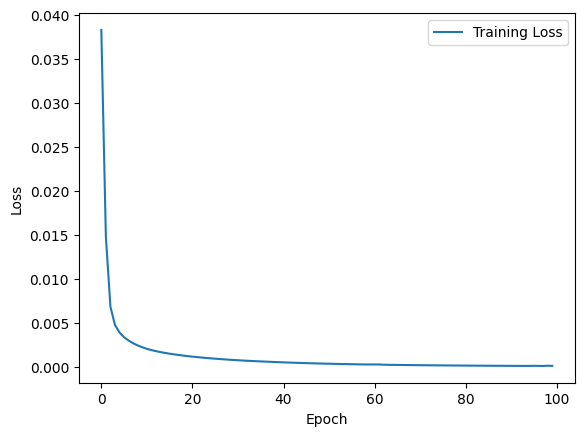

In [15]:
# Plot Training Loss
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### 画像比較
オートエンコーダーモデルによって再構成された画像と元の画像を比較するために、画像をプロットする関数 plot_reconstructed_images を定義し、入力された画像と、それをモデルが再構成した画像を並べて可視化します。

In [16]:
def plot_reconstructed_images(trainset_normal, model):
    n = 5
    fig = plt.figure(figsize=(10, 4))  # プロットのサイズを指定
    for i in range(n):
        # 元画像の表示
        plt.subplot(2, n, i + 1)
        img = trainset_normal[i][0].unsqueeze(0)
        plt.imshow(img.squeeze().numpy(), cmap='jet')
        plt.axis('off')  # 軸のラベルをオフにする
        
        # 再構成された画像の表示
        with torch.no_grad():
            img = img.float()
            output_1, output_2 = model(img)
            plt.subplot(2, n, i + 1 + n)
            output_2 = output_2.view(1, 80, 120)
            plt.imshow(output_2.squeeze().numpy(), cmap='jet')
            plt.axis('off')  # 軸のラベルをオフにする

    plt.tight_layout()  # レイアウトを自動調整
    plt.show()  # プロットを表示

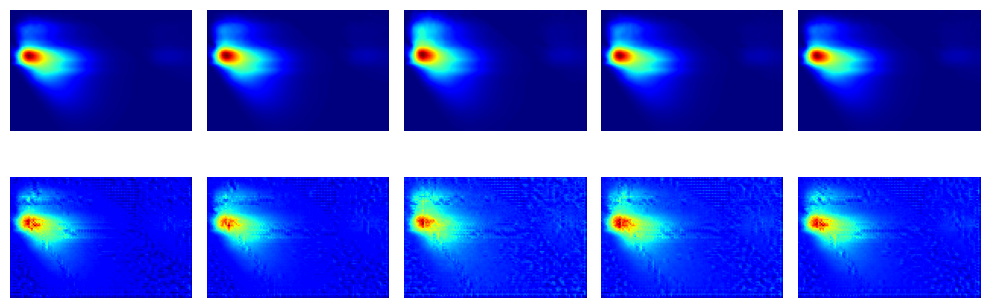

In [17]:
plot_reconstructed_images(yxqDataset(data['X_training_normal'], 
                                     labels['X_training_normal'], 
                                     transform=data_tf), 
                          model
                         )

### モデルの保存
pyTorchで訓練したモデルの状態（重みやバイアスなどのパラメータ）をファイルに保存します。

In [18]:
# Save the model
torch.save(model.state_dict(), './result/updated_model_CAO.pt')

### コードの説明

1. **`torch.save(...)`**:
   - PyTorchの`torch.save`関数を使用して、モデルの状態を保存します。
   
2. **`model.state_dict()`**:
   - モデルの状態を取得します。`state_dict()` メソッドは、モデルのパラメータ（重みやバイアスなど）を辞書形式で返します。この状態を保存することで、後でモデルを復元できます。

3. **`'./updated_model_CAO.pt'`**:
   - モデルを保存するファイル名とパスを指定しています。`'./'` は現在の作業ディレクトリを示し、`'updated_model_CAO.pt'` は保存されるファイル名です。ファイル拡張子 `.pt` は、PyTorchのモデルファイルによく使われる形式です。

## 4.データローダの復元
保存されたPyTorchモデルをロードし、さまざまなデータセットに対するデータローダーを作成します。

In [19]:
# Load Model
model.load_state_dict(torch.load('./result/updated_model_CAO.pt'))

C:\Users\japan\AppData\Local\Temp\ipykernel_21908\1689299067.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('./result/updated_model_CAO

<All keys matched successfully>

異なるデータセット（訓練用、テスト用など）に対するデータローダーを作成します。

In [20]:
# Create Loaders
training_normal_loader = DataLoader(yxqDataset(data['X_training_normal'], labels['X_training_normal'], transform=data_tf), shuffle=False)
training_loader = DataLoader(yxqDataset(data['X_training'], labels['X_training'], transform=data_tf), shuffle=False)
test_loader = DataLoader(yxqDataset(data['X_test'], labels['X_test'], transform=data_tf), shuffle=False)
pre_loader = DataLoader(yxqDataset(data['X_pre'], labels['X_pre'], transform=data_tf), shuffle=False)

この関数 CAE は、オートエンコーダーモデルを使用してデータローダーから画像を入力し、再構成された画像とロスを計算します。

In [21]:
def CAE(loader, model, criterion):
    recon_list = []
    recon2_list = []
    loss_list = []
    labels_list = []
    model.eval()
    with torch.no_grad():
        for img, labels in loader:
            img = img.float()
            recon, recon2 = model(img)
            loss = criterion(recon2, img)
            loss_list.append(loss.item())
            recon_list.extend(recon.cpu().numpy())
            recon2_list.extend(recon2.cpu().numpy())
            labels_list.extend(labels.numpy())
    
    labels = np.array(labels_list)
    loss = np.array(loss_list)
    recon = np.array(recon_list)
    recon2_list = np.array(recon2_list).reshape(-1, 80, 120)
    return labels, loss, recon, recon2_list


### コードの説明

1. **関数定義**:
   ```python
   def CAE(loader, model, criterion):
   ```
   - `loader`: データローダー（通常はトレーニングまたはテスト用のデータセット）を受け取ります。
   - `model`: 使用するオートエンコーダーモデル。
   - `criterion`: 損失関数（通常は再構成誤差を計算するためのもの）を受け取ります。

2. **リストの初期化**:
   ```python
   recon_list = []
   recon2_list = []
   loss_list = []
   labels_list = []
   ```
   - これらのリストは、再構成された画像、再構成された画像の出力、ロス、ラベルを保存するために使用されます。

3. **モデルを評価モードに設定**:
   ```python
   model.eval()
   ```
   - モデルを評価モードに切り替えます。これにより、ドロップアウトやバッチノーマリゼーションの動作が訓練時とは異なります。

4. **推論とロス計算**:
   ```python
   with torch.no_grad():
       for img, labels in loader:
           img = img.float()
           recon, recon2 = model(img)
           loss = criterion(recon2, img)
           loss_list.append(loss.item())
           recon_list.extend(recon.cpu().numpy())
           recon2_list.extend(recon2.cpu().numpy())
           labels_list.extend(labels.numpy())
   ```
   - **`torch.no_grad()`**: 勾配の計算を無効にし、メモリ使用量を減少させます。推論時には勾配が必要ないため、計算を効率化します。
   - **`for img, labels in loader:`**: データローダーからバッチを取得し、画像とラベルをそれぞれ `img` と `labels` に格納します。
   - **`recon, recon2 = model(img)`**: モデルに画像を入力し、再構成された出力（`recon` と `recon2`）を取得します。
   - **`loss = criterion(recon2, img)`**: 再構成された画像と元の画像の間のロスを計算します。
   - 各リストにロスと画像の再構成結果を追加します。`cpu().numpy()` を使うことで、PyTorchテンソルをNumPy配列に変換します。

5. **リストをNumPy配列に変換**:
   ```python
   labels = np.array(labels_list)
   loss = np.array(loss_list)
   recon = np.array(recon_list)
   recon2_list = np.array(recon2_list).reshape(-1, 80, 120)
   ```
   - 最後に、各リストをNumPy配列に変換し、`recon2_list` は再構成された画像の形状を `(バッチ数, 80, 120)` に整形します。

6. **戻り値**:
   ```python
   return labels, loss, recon, recon2_list
   ```
   - 関数は、ラベル、ロス、再構成された画像、2番目の再構成された画像を返します。

In [22]:
# Compute Reconstruction Loss
training_normal_label, training_normal_loss, training_normal_recon, training_normal_recon2 = CAE(
    training_normal_loader, 
    model, 
    criterion
    )

training_label, training_loss, training_recon, training_recon2 = CAE(
    training_loader, 
    model, 
    criterion
    )

## 5.異常値検出

異常検出のための手法を実装しています。具体的には、ボックスプロットの外れ値判定、局所外れ値因子（LOF）を使用した異常検出、そしてオートエンコーダー（CAE）に基づいた異常検出を行い、訓練データの混同行列を表示するためのものです。

#### 全体の流れ
1. **外れ値をボックスプロットで検出**: `box_outlier` 関数を用いて、損失データに基づいて外れ値を検出します。
2. **異常検出の予測**: `OCC_CAE_class` 関数を使用して、ボックスプロットとLOFに基づく異常の予測を行います。
3. **混同行列の表示**: 異常検出の結果を `print_confusion_matrix` 関数で表示し、分類のパフォーマンスを評価します。

このコードを通じて、データに対する異常検出のパフォーマンスを定量化し、結果を評価することができます。

In [23]:
def box_outlier(df, label):
    Q1 = df.quantile(q=0.25)
    Q3 = df.quantile(q=0.75)
    up_whisker = Q3 + 1.5 * (Q3 - Q1)
    low_whisker = Q1 - 1.5 * (Q3 - Q1)
    
    outliers = df[(df > up_whisker) | (df < low_whisker)]
    data = pd.DataFrame({'id': outliers.index, 'Outlier': outliers, 'label': label[outliers.index]})
    return data, Q1, Q3, up_whisker, low_whisker, outliers.index



1. **ボックスプロットによる外れ値検.index
   ```

   - **関数の説明**:
     - 入力されたデータフレーム `df` の四分位数（Q1、Q3）を計算し、外れ値の上限（`up_whisker`）と下限（`low_whisker`）を設定します。
     - これを基に外れ値を検出し、その情rix` 関数で表示し、分類のパフォーマンスを評価します。

このコードを通じて、データに対する異常検出のパフォーマンスを定量化し、結果を評価することができます。

In [24]:
def OCC_CAE_class(label, loss, recon, up_whisker, training_normal_recon):
    loss_index_abnormal = np.flatnonzero(loss > up_whisker)
    boxplot_prelabel = np.zeros(len(label))
    boxplot_prelabel[loss_index_abnormal] = 1

    clf = PYOD_LOF(contamination=0.01)
    clf.fit(training_normal_recon)
    lof_prelabel = clf.predict(recon)

    oc_cae_prelabel = boxplot_prelabel + lof_prelabel
    oc_cae_prelabel[oc_cae_prelabel > 0] = 1
    
    return label, boxplot_prelabel, lof_prelabel, oc_cae_prelabel

   - **関数の説明**:
     - ボックスプロットを用いた異常の予測ラベルを作成します。
     - `PYOD_LOF`（局所外れ値因子）を用いて、再構成されたデータに対して異常検出を行います。
     - ボックスプロットとLOFの予測を組み合わせて、最終的な異常検出ラベルを作成します。

In [25]:
def print_confusion_matrix(label, preds, set_name):
    print(f"{set_name} Classification:")
    print(f"Confusion Matrix:\n{metrics.confusion_matrix(label, preds)}")
    tp, fn, fp, tn = metrics.confusion_matrix(label, preds).ravel()
    print(f"tp: {tp}, fn: {fn}, fp: {fp}, tn: {tn}")
    specificity = tn / (tn + fp)
    print(f"Accuracy: {metrics.accuracy_score(label, preds)}")
    print(f"Specificity: {specificity}\n")

   - **関数の説明**:
     - 与えられたラベルと予測値から混同行列を計算し、その結果を出力します。
     - 真陽性（TP）、偽陰性（FN）、偽陽性（FP）、真陰性（TN）を取得し、精度と特異度を計算して表示します。

In [26]:
df_loss = pd.DataFrame(training_normal_loss, columns=['value'])
df_loss = df_loss.iloc[:, 0]

In [27]:
result, Q1, Q3, up_whisker, low_whisker, outlier_index = box_outlier(df_loss, training_normal_label)

<Axes: >

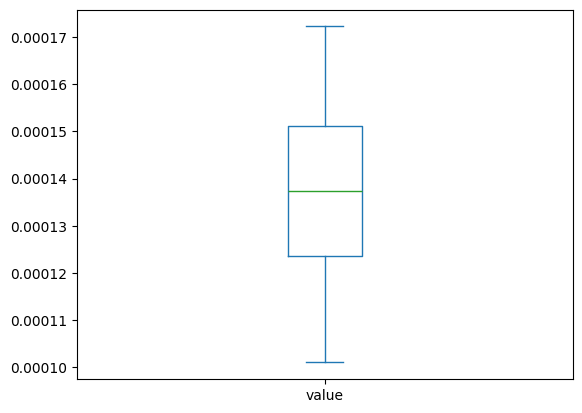

In [29]:
# box plot
fig,axes = plt.subplots()
df_loss.plot(kind='box',ax=axes)

In [30]:
# Classify Training Set
label_training, Boxplot_training, LOF_training, OC_CAE_training = OCC_CAE_class(training_label, training_loss, training_recon, up_whisker, training_normal_recon)

print_confusion_matrix(label_training, Boxplot_training, "Training Set (Boxplot)")
print_confusion_matrix(label_training, LOF_training, "Training Set (LOF)")
print_confusion_matrix(label_training, OC_CAE_training, "Training Set (OC-CAE)")

Training Set (Boxplot) Classification:
Confusion Matrix:
[[25  0]
 [11 61]]
tp: 25, fn: 0, fp: 11, tn: 61
Accuracy: 0.8865979381443299
Specificity: 0.8472222222222222

Training Set (LOF) Classification:
Confusion Matrix:
[[25  0]
 [49 23]]
tp: 25, fn: 0, fp: 49, tn: 23
Accuracy: 0.4948453608247423
Specificity: 0.3194444444444444

Training Set (OC-CAE) Classification:
Confusion Matrix:
[[25  0]
 [10 62]]
tp: 25, fn: 0, fp: 10, tn: 62
Accuracy: 0.8969072164948454
Specificity: 0.8611111111111112



## 6.再成形
関数 `reshape_data` は、距離ベースの外れ値検出のためにデータを整形するためのものです。次元が `(高さ, 幅, サンプル数)` の3Dデータを、距離ベースの外れ値検出アルゴリズムに適した形式に変換するために使用されます。

In [31]:
# Reshape Data for Distance-Based Outlier Detection
def reshape_data(data):
    k = data.shape[2]
    data_reshaped = data.transpose(2, 0, 1).reshape(k, -1)
    return data_reshaped

### コードの説明

1. **関数定義**:
   ```python
   def reshape_data(data):
   ```
   - `data`: 入力データは通常、3次元のNumPy配列であり、形状は `(高さ, 幅, サンプル数)` です。

2. **データの次元数を取得**:
   ```python
   k = data.shape[2]
   ```
   - `k` には、サンプル数が格納されます。データの形状から3次元目のサイズを取得しています。

3. **データの整形**:
   ```python
   data_reshaped = data.transpose(2, 0, 1).reshape(k, -1)
   ```
   - `data.transpose(2, 0, 1)`: ここでデータの次元を変更し、3次元目を最初の次元に移動させます。新しい形状は `(サンプル数, 高さ, 幅)` になります。
   - `.reshape(k, -1)`: その後、データを `(サンプル数, 高さ * 幅)` の2次元配列に変形します。ここで `-1` は自動的にサイズを計算するために使用されます。

4. **戻り値**:
   ```python
   return data_reshaped
   ```
   - 整形されたデータを返します。

In [32]:
X_training_normal_reshaped = reshape_data(data['X_training_normal'])
X_training_reshaped = reshape_data(data['X_training'])
X_test_reshaped = reshape_data(data['X_test'])
X_pre_reshaped = reshape_data(data['X_pre'])

### 距離による異常値の排除
この関数 `dist` は、与えられたデータポイントから原点までのユークリッド距離を計算するためのものです。距離ベースの外れ値検出アルゴリズムで特に重要です。距離の計算により、異常なデータポイントを特定できます。

In [33]:
# Distance-Based Outlier Detection
def dist(X):
    return np.sqrt(np.sum(X ** 2, axis=1))

### コードの説明

1. **関数定義**:
   ```python
   def dist(X):
   ```
   - `X`: この引数は、各行が1つのデータポイントであり、各列がそのポイントの特徴を表す2次元のNumPy配列（行列）を期待します。

2. **ユークリッド距離の計算**:
   ```python
   return np.sqrt(np.sum(X ** 2, axis=1))
   ```
   - `X ** 2`: 各データポイントの各特徴を2乗します。
   - `np.sum(..., axis=1)`: 行ごとに合計を計算します。これにより、各データポイントの特徴の2乗の合計が得られます。
   - `np.sqrt(...)`: 合計の平方根を取ることで、ユークリッド距離が計算されます。これにより、各データポイントが原点からどれだけ離れているかを示すスカラー値が得られます。

In [34]:
dist_training_normal = dist(X_training_normal_reshaped)
dist_training = dist(X_training_reshaped)
dist_test = dist(X_test_reshaped)
dist_pre = dist(X_pre_reshaped)

In [35]:
df_dist = pd.DataFrame(dist_training_normal, columns=['value'])
df_dist = df_dist.iloc[:, 0]
result, Q1, Q3, up_whisker, low_whisker, outlier_index = box_outlier(df_dist, labels['X_training_normal'])

### 外れ値の識別
この関数 `dist_boxclass` は、距離に基づいて外れ値を識別し、その結果をラベルとして返します。正常なデータポイントは `0`、異常なデータポイントは `1` で表されます。

In [36]:
def dist_boxclass(dist, label, up_whisker, low_whisker):
    abnormal_indices = np.flatnonzero((dist < low_whisker) | (dist > up_whisker))
    dist_prelabel = np.zeros(len(label))
    dist_prelabel[abnormal_indices] = 1
    return dist_prelabel

### コードの説明

1. **関数定義**:
   ```python
   def dist_boxclass(dist, label, up_whisker, low_whisker):
   ```
   - `dist`: 各データポイントの距離を含むNumPy配列。
   - `label`: データポイントの元のラベルを含む配列。外れ値検出後の評価に使用される。
   - `up_whisker`: 上限値（外れ値の上限）を指定するスカラー値。
   - `low_whisker`: 下限値（外れ値の下限）を指定するスカラー値。

2. **異常値のインデックスを特定**:
   ```python
   abnormal_indices = np.flatnonzero((dist < low_whisker) | (dist > up_whisker))
   ```
   - `dist < low_whisker`: 下限を下回る距離を持つポイントを見つける条件。
   - `dist > up_whisker`: 上限を超える距離を持つポイントを見つける条件。
   - `np.flatnonzero(...)`: これらの条件を満たすインデックスを取得し、異常値のインデックスを `abnormal_indices` に格納します。

3. **異常値のラベル付け**:
   ```python
   dist_prelabel = np.zeros(len(label))
   dist_prelabel[abnormal_indices] = 1
   ```
   - `np.zeros(len(label))`: ラベル配列と同じ長さのゼロ配列を作成します。この配列は、すべてのデータポイントを正常と見なすことを示します。
   - `dist_prelabel[abnormal_indices] = 1`: 異常値のインデックスに対して `1` を設定することで、これらのポイントを異常としてラベル付けします。

4. **戻り値**:
   ```python
   return dist_prelabel
   ```
   - 異常値のラベルを持つ配列 `dist_prelabel` を返します。正常なデータポイントは `0`、異常なデータポイントは `1` で表されます。

In [37]:
dist_trainlabel = dist_boxclass(dist_training, labels['X_training'], up_whisker, low_whisker)
print_confusion_matrix(labels['X_training'], dist_trainlabel, "Training Set")

dist_testlabel = dist_boxclass(dist_test, labels['X_test'], up_whisker, low_whisker)
print_confusion_matrix(labels['X_test'], dist_testlabel, "Test Set")

dist_prelabel = dist_boxclass(dist_pre, labels['X_pre'], up_whisker, low_whisker)
print_confusion_matrix(labels['X_pre'], dist_prelabel, "Prediction Set")

Training Set Classification:
Confusion Matrix:
[[20  5]
 [69  3]]
tp: 20, fn: 5, fp: 69, tn: 3
Accuracy: 0.23711340206185566
Specificity: 0.041666666666666664

Test Set Classification:
Confusion Matrix:
[[ 8  0]
 [23  1]]
tp: 8, fn: 0, fp: 23, tn: 1
Accuracy: 0.28125
Specificity: 0.041666666666666664

Prediction Set Classification:
Confusion Matrix:
[[3 0]
 [7 2]]
tp: 3, fn: 0, fp: 7, tn: 2
Accuracy: 0.4166666666666667
Specificity: 0.2222222222222222



### LOF（Local Outlier Factor）アルゴリズムによる外れ値の検知

このコードは、PyODライブラリを用いてLOF（Local Outlier Factor）アルゴリズムを実行し、訓練セット、テストセット、予測セットに対する外れ値検出を行うものです。LOFアルゴリズムを使用することで、データの局所的な密度に基づいて外れ値を特定できます。

In [38]:
# LOF Algorithm
clf_lof = PYOD_LOF(contamination=0.01)
clf_lof.fit(X_training_normal_reshaped)

LOF(algorithm='auto', contamination=0.01, leaf_size=30, metric='minkowski',
  metric_params=None, n_jobs=1, n_neighbors=20, novelty=True, p=2)


### コードの説明

1. **LOFアルゴリズムの初期化**:
   ```python
   clf_lof = PYOD_LOF(contamination=0.01)
   ```
   - `PYOD_LOF`: PyODライブラリのLOFアルゴリズムのクラスをインスタンス化しています。
   - `contamination=0.01`: データセットに含まれる外れ値の割合を設定しています。ここでは1%を指定しています。

2. **訓練データのフィッティング**:
   ```python
   clf_lof.fit(X_training_normal_reshaped)
   ```
   - `X_training_normal_reshaped`: リシェイプされた正常な訓練データを使ってLOFモデルをフィットさせます。このステップでモデルはデータのパターンを学習します。

In [39]:
#訓練セットの外れ値予測
lof_trainlabel = clf_lof.predict(X_training_reshaped)
print_confusion_matrix(labels['X_training'], lof_trainlabel, "Training Set (LOF)")

#テストセットの外れ値予測
lof_testlabel = clf_lof.predict(X_test_reshaped)
print_confusion_matrix(labels['X_test'], lof_testlabel, "Test Set (LOF)")

#予測セットの外れ値予測
lof_prelabel = clf_lof.predict(X_pre_reshaped)
print_confusion_matrix(labels['X_pre'], lof_prelabel, "Prediction Set (LOF)")

Training Set (LOF) Classification:
Confusion Matrix:
[[25  0]
 [23 49]]
tp: 25, fn: 0, fp: 23, tn: 49
Accuracy: 0.7628865979381443
Specificity: 0.6805555555555556

Test Set (LOF) Classification:
Confusion Matrix:
[[ 7  1]
 [ 8 16]]
tp: 7, fn: 1, fp: 8, tn: 16
Accuracy: 0.71875
Specificity: 0.6666666666666666

Prediction Set (LOF) Classification:
Confusion Matrix:
[[3 0]
 [3 6]]
tp: 3, fn: 0, fp: 3, tn: 6
Accuracy: 0.75
Specificity: 0.6666666666666666



### One-Class SVM（サポートベクターマシン）による異常検知

このコードは、One-Class SVM（サポートベクターマシン）を用いて異常検知のためのハイパーパラメータチューニングを行い、最適な gamma と nu の値を見つけるものです。なお、`One-Class SVM` は高次元データでのパフォーマンスが低下する可能性があるため、次元削減手法（PCAなど）を適用することが有効です。

In [ ]:
# One-Class SVM
gammas = np.logspace(-4, 2, 7)
nus = np.linspace(0.01, 0.99, 99)

best_score = 0
model_svm = OneClassSVM()

for gamma in gammas:
    for nu in nus:
        model_svm.set_params(kernel='rbf', gamma=gamma, nu=nu)
        model_svm.fit(X_training_normal_reshaped)
        y_train_pred = model_svm.predict(X_training_reshaped)
        y_test_pred = model_svm.predict(X_test_reshaped)
        y_pre_pred = model_svm.predict(X_pre_reshaped)

        y_train_pred = np.where(y_train_pred == 1, 0, 1)
        y_test_pred = np.where(y_test_pred == 1, 0, 1)
        y_pre_pred = np.where(y_pre_pred == 1, 0, 1)

        score = metrics.accuracy_score(labels['X_training'], y_train_pred) + \
                metrics.accuracy_score(labels['X_test'], y_test_pred) + \
                metrics.accuracy_score(labels['X_pre'], y_pre_pred)
        
        if score > best_score:
            best_score = score
            best_parameters = {'gamma': gamma, 'nu': nu}

print(f"Best Score: {best_score:.2f}")
print(f"Best Parameters: {best_parameters}")


### コードの説明

1. **ハイパーパラメータの設定**:
   ```python
   gammas = np.logspace(-4, 2, 7)
   nus = np.linspace(0.01, 0.99, 99)
   ```
   - `gammas`: 指数的にスケーリングされた値を持つ配列で、`gamma` の範囲を -4 から 2 までの 7 つの値に分割しています。`gamma` はRBFカーネルの幅を決定します。
   - `nus`: 0.01から0.99までの99個の値を持つ配列で、`nu` は外れ値の割合を示します。

2. **スコアの初期化**:
   ```python
   best_score = 0
   model_svm = OneClassSVM()
   ```
   - `best_score`: 最良のスコアを保持するための変数を初期化します。
   - `model_svm`: One-Class SVMのインスタンスを生成します。

3. **ハイパーパラメータの組み合わせを試すループ**:
   ```python
   for gamma in gammas:
       for nu in nus:
           model_svm.set_params(kernel='rbf', gamma=gamma, nu=nu)
           model_svm.fit(X_training_normal_reshaped)
           y_train_pred = model_svm.predict(X_training_reshaped)
           y_test_pred = model_svm.predict(X_test_reshaped)
           y_pre_pred = model_svm.predict(X_pre_reshaped)
   ```
   - 各 `gamma` と `nu` の組み合わせに対して、モデルのパラメータを設定し、正常な訓練データでモデルをフィットさせます。
   - 訓練データ、テストデータ、予測データに対して予測を行います。

4. **予測ラベルの調整**:
   ```python
   y_train_pred = np.where(y_train_pred == 1, 0, 1)
   y_test_pred = np.where(y_test_pred == 1, 0, 1)
   y_pre_pred = np.where(y_pre_pred == 1, 0, 1)
   ```
   - One-Class SVMの予測は、`1`（正常）または `-1`（異常）であるため、これを `0`（正常）または `1`（異常）に変換しています。

5. **スコアの計算**:
   ```python
   score = metrics.accuracy_score(labels['X_training'], y_train_pred) + \
           metrics.accuracy_score(labels['X_test'], y_test_pred) + \
           metrics.accuracy_score(labels['X_pre'], y_pre_pred)
   ```
   - 各データセットの精度を計算し、合計スコアを求めます。

6. **最良のスコアとパラメータの更新**:
   ```python
   if score > best_score:
       best_score = score
       best_parameters = {'gamma': gamma, 'nu': nu}
   ```
   - 現在のスコアが過去の最良スコアよりも高い場合、最良のスコアとそのときのパラメータを更新します。

### モデル化と評価
前のハイパーパラメータチューニングで見つけた最良の gamma と nu のパラメータを使用して、One-Class SVM モデルを訓練する部分です。

In [ ]:
model_svm.set_params(**best_parameters)
model_svm.fit(X_training_normal_reshaped)

In [ ]:
def classify_with_svm(X_data, labels, model):
    preds = model.predict(X_data)
    preds = np.where(preds == 1, 0, 1)
    print_confusion_matrix(labels, preds, "Set")

In [ ]:
classify_with_svm(X_training_reshaped, labels['X_training'], model_svm)
classify_with_svm(X_test_reshaped, labels['X_test'], model_svm)
classify_with_svm(X_pre_reshaped, labels['X_pre'], model_svm)